Ash Rai <br>
CSC 675: Neural Network and Deep Learning<br>
Spring 2021

# Deep Learning Project 2 : Part 1




## Implementation

### Preprocessing the dataset

Loading the MNIST Dataset

In [ ]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

Example of the pictures

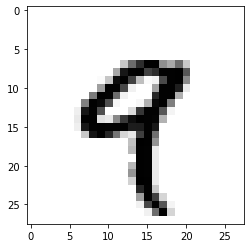

In [ ]:
digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

Dimension Values

In [ ]:

m_train = train_images.shape[0]
m_test = test_images.shape[0]
num_px = train_images.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))

Number of training examples: m_train = 60000
Number of testing examples: m_test = 10000
Height/Width of each image: num_px = 28
Each image is of size: (28, 28
train_images shape: (60000, 28, 28)
train_labels shape: (60000,)
test_images shape: (10000, 28, 28)
test_labels shape: (10000,)


In [ ]:
train_images_flatten =  train_images.reshape(train_images.shape[0], -1)
test_images_flatten = test_images.reshape(test_images.shape[0], -1)

print ("train_set_x_flatten shape: " + str(train_images_flatten.shape))
print ("train_set_y shape: " + str(train_labels.shape))
print ("test_images_flatten shape: " + str(test_images_flatten.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("sanity check after reshaping: " + str(train_images_flatten[0:5,0]))

train_set_x_flatten shape: (60000, 784)
train_set_y shape: (60000,)
test_images_flatten shape: (10000, 784)
test_labels shape: (10000,)
sanity check after reshaping: [0 0 0 0 0]


Standarding the dataset

In [ ]:
train_images_processed = train_images_flatten/255
test_images_processed = test_images_flatten/255

Setting up the dataset for the run. This part has two purposes:


1.   Altering dataset into a binary classification problem, by classifying for the given training_digit
2.   Sample it to have equal images for the training digit images and non-training digit images

In [ ]:
def setup_new_dataset(training_digit):
  # setting up train dataset
  unique, counts = np.unique(train_labels, return_counts=True)
  number_of_training_digits = dict(zip(unique, counts))[0]

  sampled_digit_count = 0
  sampled_non_digit_count = 0

  sampled_train_images_list = []
  sampled_train_labels_list = [[]]

  for i in range(train_labels.shape[0]):
    if (train_labels[i] == training_digit and sampled_digit_count < number_of_training_digits):
      sampled_train_images_list.append(train_images_processed[i].tolist())
      sampled_train_labels_list[0].append(1)
      sampled_digit_count += 1

    elif (train_labels[i] != training_digit and sampled_non_digit_count < number_of_training_digits):
      sampled_train_images_list.append(train_images_processed[i].tolist())
      sampled_train_labels_list[0].append(0)
      sampled_non_digit_count += 1

    if (sampled_digit_count == number_of_training_digits and sampled_non_digit_count == number_of_training_digits):
      # sampling complete, with equal number of training_digit images and non-training_digit images
      break
  
  # setting up test dataset
  unique, counts = np.unique(test_labels, return_counts=True)
  number_of_test_digits = dict(zip(unique, counts))[0]

  sampled_digit_count = 0
  sampled_non_digit_count = 0

  sampled_test_images_list = []
  sampled_test_labels_list = [[]]

  for i in range(test_labels.shape[0]):
    if (test_labels[i] == training_digit and sampled_digit_count < number_of_test_digits):
      sampled_test_images_list.append(test_images_processed[i].tolist())
      sampled_test_labels_list[0].append(1)
      sampled_digit_count += 1

    elif (test_labels[i] != training_digit and sampled_non_digit_count < number_of_test_digits):
      sampled_test_images_list.append(test_images_processed[i].tolist())
      sampled_test_labels_list[0].append(0)
      sampled_non_digit_count += 1

    if (sampled_digit_count == number_of_test_digits and sampled_non_digit_count == number_of_test_digits):
      # sampling complete, with equal number of training_digit images and non-training_digit images
      break

  return np.array(sampled_train_images_list).T, np.array(sampled_train_labels_list), np.array(sampled_test_images_list).T, np.array(sampled_test_labels_list)

### Neural Network Implementation

Sigmoid function implementation

In [ ]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = 1 / (1 + np.exp(-z))
    return s

Initializing parameters

In [ ]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim, 1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

 Forward and Backward propagation

In [ ]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    A = sigmoid(np.dot(w.T, X) + b)                                    # compute activation
    cost = (-1 / m) * (np.sum((Y * np.log(A)) + ((1 - Y) * np.log(1 - A))))                         # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1 / m) * (np.dot(X, (A - Y).T))
    db = (1 / m) * np.sum(A - Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

Optimization

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        # Cost and gradient calculation (≈ 1-4 lines of code)
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        w = w - (learning_rate * dw)
        b = b - (learning_rate * db)
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

Prediction

In [ ]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):   
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if (A[0, i] >= 0.5):
          Y_prediction[0, i] = 1
        else:
          Y_prediction[0, i] = 0

    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

Merge all functions into a model

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

Training the model

In [ ]:
sampled_train_images, sampled_train_labels, sampled_test_images, sampled_test_labels = setup_new_dataset(0)
d = model(sampled_train_images, sampled_train_labels, sampled_test_images, sampled_test_labels, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.375061
Cost after iteration 200: 0.282723
Cost after iteration 300: 0.238480
Cost after iteration 400: 0.211917
Cost after iteration 500: 0.193837
Cost after iteration 600: 0.180531
Cost after iteration 700: 0.170207
Cost after iteration 800: 0.161890
Cost after iteration 900: 0.154997
Cost after iteration 1000: 0.149160
Cost after iteration 1100: 0.144130
Cost after iteration 1200: 0.139733
Cost after iteration 1300: 0.135846
Cost after iteration 1400: 0.132375
Cost after iteration 1500: 0.129249
Cost after iteration 1600: 0.126415
Cost after iteration 1700: 0.123828
Cost after iteration 1800: 0.121455
Cost after iteration 1900: 0.119266
train accuracy: 96.75839945973324 %
test accuracy: 97.65306122448979 %


### Results

Plotting cost function and the gradients

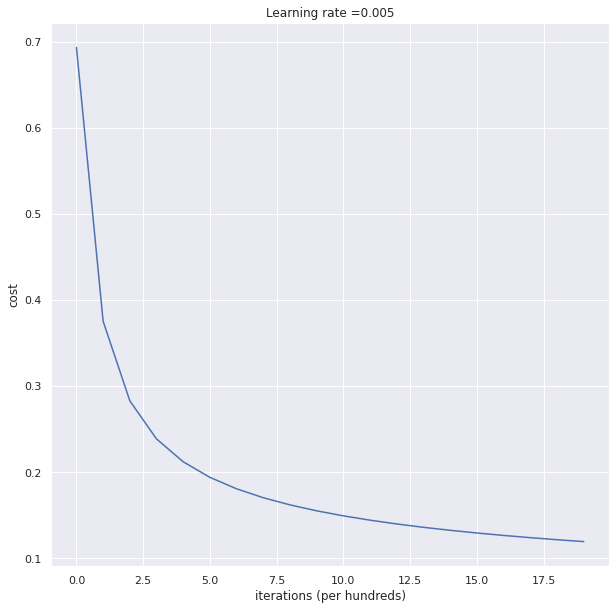

In [ ]:
import seaborn as sns

# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
sns.set_theme(style="darkgrid")
#sns.lineplot(costs)
plt.figure(figsize=(10,10))
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

Choice of Learning Rate (applied to digit 0)



learning rate is: 0.01
train accuracy: 97.03697450616242 %
test accuracy: 97.70408163265306 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 94.63109910518318 %
test accuracy: 96.22448979591837 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 86.9745061624177 %
test accuracy: 88.77551020408163 %

-------------------------------------------------------



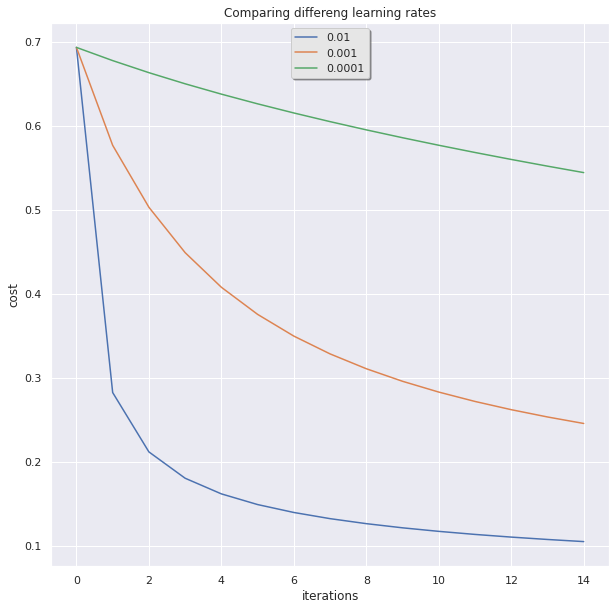

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
sampled_train_images, sampled_train_labels, sampled_test_images, sampled_test_labels = setup_new_dataset(0)

for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(sampled_train_images, sampled_train_labels, sampled_test_images, sampled_test_labels, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

plt.figure(figsize=(10,10))
for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Comparing differeng learning rates")

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

In [ ]:
classification_digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
models = {}

for i in classification_digits:
    print ("Digit for classification: " + str(i))
    sampled_train_images, sampled_train_labels, sampled_test_images, sampled_test_labels = setup_new_dataset(i)
    model(sampled_train_images, sampled_train_labels, sampled_test_images, sampled_test_labels, num_iterations = 2000, learning_rate = 0.01, print_cost = False)
    print('-----------------------------------------------------')

Digit for classification: 0
train accuracy: 97.28178288029714 %
test accuracy: 97.95918367346938 %
-----------------------------------------------------
Digit for classification: 1
train accuracy: 97.40840790140132 %
test accuracy: 97.55102040816327 %
-----------------------------------------------------
Digit for classification: 2
train accuracy: 93.23822387303731 %
test accuracy: 93.62244897959184 %
-----------------------------------------------------
Digit for classification: 3
train accuracy: 92.6304237717373 %
test accuracy: 91.73469387755102 %
-----------------------------------------------------
Digit for classification: 4
train accuracy: 94.7726306842329 %
test accuracy: 94.89795918367346 %
-----------------------------------------------------
Digit for classification: 5
train accuracy: 91.00846262341327 %
test accuracy: 89.69017094017094 %
-----------------------------------------------------
Digit for classification: 6
train accuracy: 96.5627903048729 %
test accuracy: 96.594

## Analysis

**Are there digits in the MNIST dataset that seem harder to classify? If so, did you see similar trends when you applied unsupervised learning in Project 1?**

The results from the classification here seems to be in line with my results from project 1. In project 1, looking at my confusion matrix for the clustering, '1' and '0' were the best performers. This is the case with the classification resuls from this project as well, where '0' and '1' have the best accuracy between 97% and 98% for both the train and test datasets, for both digits. Conversely, in project 1, '5', '8' and '9' were the worst performers. This is also in line again with my results here, with the 3 digits having the lowest 3 accuracy among all the 10 digits. I believe this comes down to the fact that '0' and '1' are the most unique digits in terms of visual representation, wheras '5', '8' and '9' have similar counterparts (for instance, '5' vs '6' and '8' vs '9'). The similar representation leads to mislabeling by the model, affecting the accuracy.

<br>

**How do the learning curve, the train accuracy, and the test accuracy change as function of the learning rate assuming a fix number of iterations (say, 2000 iterations)?**

I ran different values of the learning rate at 0.01, 0.001 and 0.0001 at 2000 iterations for the digit '0'. The accuracy was the best for the learning rate of 0.01 (about 97% for both train and test datasets), with a small drop for the learning rate of 0.001 (94% train accuracy and 96% test accuracy). However, the accuracy dropped fairly significantly for the value of 0.0001 at 87% train accuracy and 89% test accuracy. 

It seemed like the accuracy got worse as the learning rate got smaller. Following up on that, for the cost trend, the cost at all points of the iteration also suffered as the learning rates got smaller. Cost at all points is best for the learning rate of 0.01, folllowed by 0.001 and then 0.0001.


<br>

**What do you think about the accuracy results you are getting? Do you trust them? Why or why not. Hint: Think about how you preprocessed the MNIST data to set up your binary classification problem.**

I am fairly confident about the accuracy results, as long as the labeling in MNIST dataset itself is reliable. For my preprocessing to set up the binary classification problem, I followed the following steps:

1. Iterated through the dataset, choosing all the images for the classification digit, and an equal number of images of other digits.
2.I created a new label set using the MNIST label, where 1 indicated the positive classification and 0 indicated a negative one.
3. The images and the label were sampled in a coupled way, so they should be in proper order.
4. I counted the total count of the classification digit beforehand, so that we have an equal number of positive and negative classification data points.
5. Since MNIST dataset is already fairly random, I did not worry my negative data points (images) being heavily skewed towards any particular digit/s even though their distribution in the context of the full dataset could be concentrated.

<br>

**Your algorithm has learned a weight vector and a bias value. Is there something you can say about the weight vector? Is there meaning to it or is it just a useless byproduct?**

The weight vector determines the importance of each feature from the input in terms of the output. A lower weight value will mean that the corresponding input feature with have a smaller influence on the output while the higher weight value will mean a higher influence from the corresonding input feature. In our model, since each pixel is a feature itself, the weight vector determines the importance of each pixel in terms of determining the digit. So I would think that a pixel, say at the left top corner of the image which probably would not have any part of the digit drawn, would have a low influence on the output and hence a lower value in the corresponding weight vector. Pixels near the center of the image might have higher corresponding weight values conversely since the nuances of the digit representation is heavily located there.